### An example of Non-dominated sorting
[DEAP - Distributed Evolutionary Algorithms in Python](https://github.com/DEAP/deap)

In [1]:
import math
import random
import array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] ='\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'

In [2]:
from deap import tools, creator, base

## an illustrative MOP problem: Dent

$$
\begin{array}{rl}
\text{minimize} & f_1(\vec{x}),f_2(\vec{x}) \\
\text{such that} & f_1(\vec{x}) = \frac{1}{2}\left( \sqrt{1 + (x_1 + x_2)^2} + \sqrt{1 + (x_1 - x_2)^2} + x_1 -x_2\right) + d,\\
 & f_2(\vec{x}) = \frac{1}{2}\left( \sqrt{1 + (x_1 + x_2)^2} + \sqrt{1 + (x_1 - x_2)^2} - x_1 + x_2\right) + d,\\
\text{with}& d = \lambda e^{-\left(x_1-x_2\right)^2}\ (\text{generally }\lambda=0.85) \text{ and } \vec{x}\in \left[-1.5,1.5\right]^2.
\end{array}
$$

In [3]:
def dent(individual, labda=0.85):
    x1 = individual[0]
    x2 = individual[1]
    
    d = labda * math.exp(-(x1-x2)**2)
    
    f1 = 0.5 * (math.sqrt(1 + (x1 + x2)**2) + math.sqrt(1 + (x1 - x2)**2) + x1 - x2) + d
    f2 = 0.5 * (math.sqrt(1 + (x1 + x2)**2) + math.sqrt(1 + (x1 - x2)**2) - x1 + x2) + d
    return f1, f2

## Non-dominated sorting

In [5]:
from collections import defaultdict

In [6]:
def nondominate_sorting(individuals, k):
    map_fit_ind = defaultdict(list)
    for ind in individuals:
        map_fit_ind[ind.fitness].append(ind)
    fits = map_fit_ind.keys()

    f_set = []
    for f in fits:
        f_set.append(f)
    fits = f_set
    
    current_front = []
    next_front = []
    dominating_fits = defaultdict(int)
    dominated_fits = defaultdict(list)
    
    # first front
    for i, fit_i in enumerate(fits):
        for fit_j in fits[i+1:]:
            if fit_i.dominates(fit_j):
                dominating_fits[fit_j] += 1
                dominated_fits[fit_i].append(fit_j)
            elif fit_j.dominates(fit_i):
                dominating_fits[fit_i] += 1
                dominated_fits[fit_j].append(fit_i)
        if dominating_fits[fit_i] == 0:
            current_front.append(fit_i)
    
    fronts = [[]]
    for fit in current_front:
        fronts[-1].extend(map_fit_ind[fit])
    pareto_sorted = len(fronts[-1])
    
    # other fronts
    N = min(len(individuals), k)
    while pareto_sorted < N:
        fronts.append([])
        for fit_p in current_front:
            for fit_d in dominated_fits[fit_p]:
                dominating_fits[fit_d] -= 1
                if dominating_fits[fit_d] == 0:
                    next_front.append(fit_d)
                    pareto_sorted += len(map_fit_ind[fit_d])
                    fronts[-1].extend(map_fit_ind[fit_d])
        current_front = next_front
        next_front = []
    return fronts

In [7]:
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)
toolbox = base.Toolbox()

def uniform(low, up, size=1):
    return [random.uniform(a, b) for a, b in zip([low,]*size, [up,]*size)]

BOUND_LOW = -1.5
BOUND_UP = 1.5
NDIM = 2
toolbox.register('attr_float', uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('evaluate', dent)

num_samples = 4
example_pop = toolbox.population(n=num_samples**NDIM)

x_samples = np.arange(BOUND_LOW, BOUND_UP, (BOUND_UP-BOUND_LOW)/num_samples)
y_samples = np.arange(BOUND_LOW, BOUND_UP, (BOUND_UP-BOUND_LOW)/num_samples)
xx, yy = np.meshgrid(x_samples, y_samples)
ind_samples = np.vstack((xx.flatten(), yy.flatten())).transpose()

for i, ind in enumerate(example_pop):
    ind[:] = ind_samples[i, :]
    
fitnesses = toolbox.map(toolbox.evaluate, example_pop)
for ind, fit in zip(example_pop, fitnesses):
    ind.fitness.values = fit

In [8]:
fronts = nondominate_sorting(example_pop, k=len(example_pop))

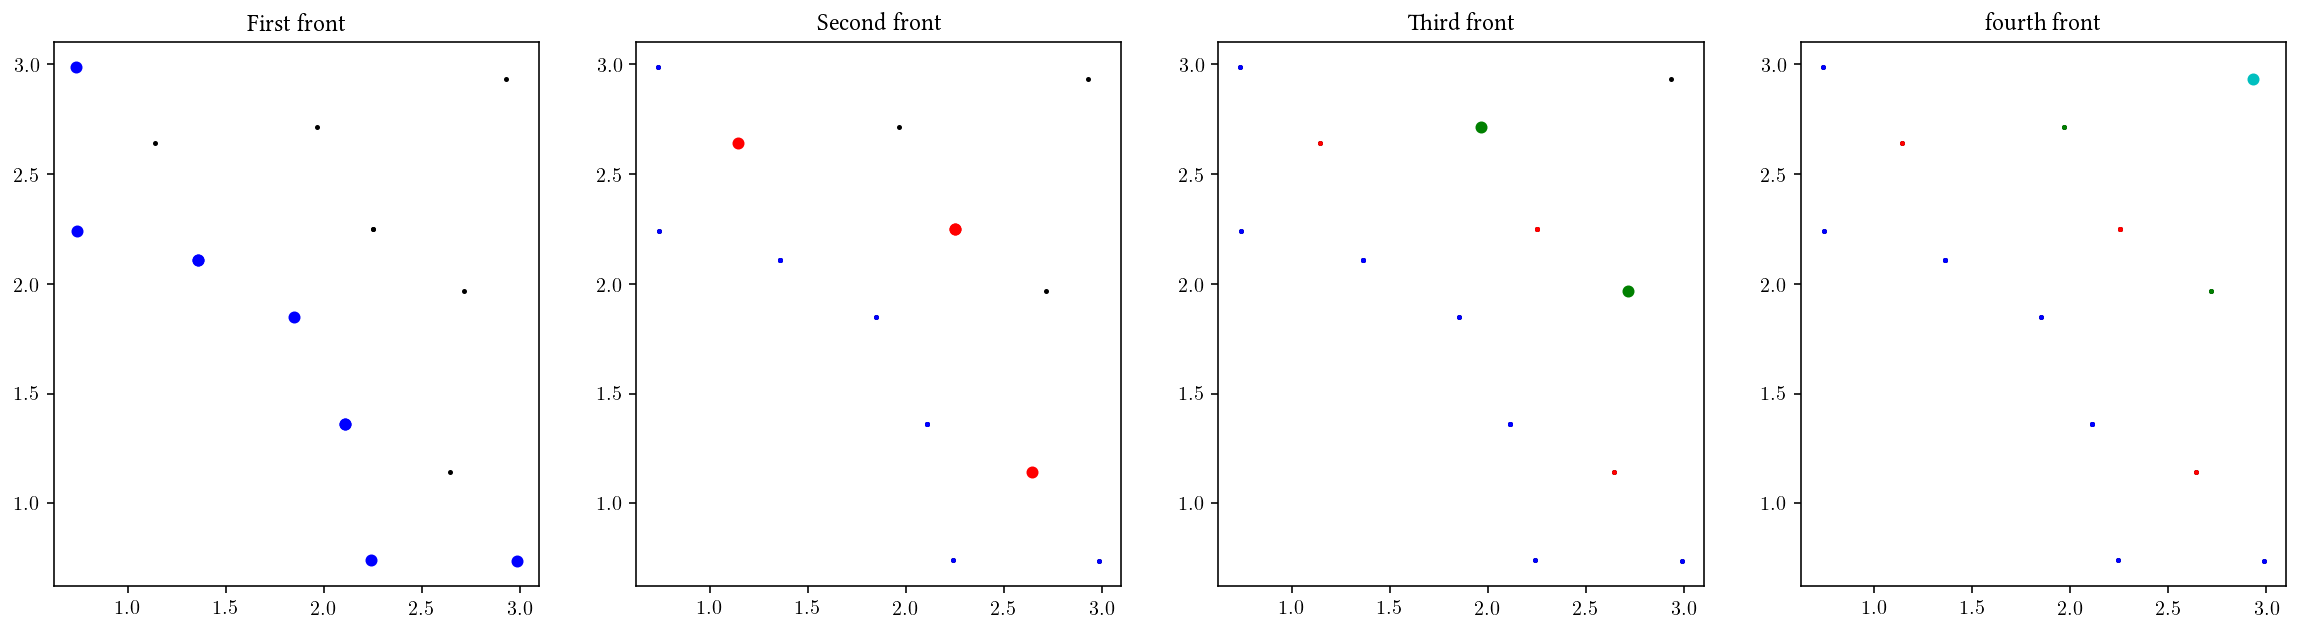

In [9]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.title('First front')
for ind in example_pop: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=3)
for ind in fronts[0]: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'b.', ms=10)
    
plt.subplot(1, 4, 2)
plt.title('Second front')
for ind in example_pop: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=3)
for ind in fronts[0]: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'b.', ms=3)
for ind in fronts[1]: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', ms=10)
    
plt.subplot(1, 4, 3)
plt.title('Third front')
for ind in example_pop: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=3)
for ind in fronts[0]: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'b.', ms=3)
for ind in fronts[1]: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', ms=3)
for ind in fronts[2]: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', ms=10)
    
plt.subplot(1, 4, 4)
plt.title('fourth front')
for ind in example_pop: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=3)
for ind in fronts[0]: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'b.', ms=3)
for ind in fronts[1]: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', ms=3)
for ind in fronts[2]: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', ms=3)
for ind in fronts[3]: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'c.', ms=10)